# Bayesian Search for Debugging: An Evaluation of BBChop

<!--
Typical Components

Title Page
Abstract
Introduction
Methods and Materials (or Equipment)
Experimental Procedure
Results
Discussion
Conclusion
References
Appendices
Further Reading
-->
## Abstract
<!--
Quick Abstract Reference

Must have:
Purpose
Key result(s)
Most significant point of discussion
Major conclusion
May Include:
Brief method
Brief theory
Restrictions:
ONE page
200 words MAX.
-->




## Introduction
<!--  Quick Intro Reference

Must Have:
Purpose of the experiment
Important background and/or theory
May include:
Description of specialized equipment
Justification of experiment’s importance
-->

The purpose of the experiment was to see whether Bayesian Search could be used for debugging. Of especial interest to me is, whether the method of Bayesian Search is still suitable for low fault probabilties or large potential fault locations.

Underlying this method is Bayesian Search theory.

*Git Bisect* is a valuable tool for many large projects [Citation Needed]. However, it falls short for non-deterministic bugs. Therefore, a tool like BBChop might be of importance. 

## Method

* I created a wrapper that runs a BBChop search on a "test" which passes if the tested location is less then "L" (named `fail_loc` in the data) or which fails with probability `fail_prob` if the tested location is larger or equal to `fail_loc`.
* To make the experiment reproducible, I seeded the pseudo-random number generator of Python and collected the seed as an input to each experiment.
* The results of each experiment is the number of trials needed for BBChop to come to a solution, and the location where the fault is believed to be (`where`).

### Infrastructure

* Python 3.4.3 was used. The code was run in a `virtualenv` with `mpmath` as a further package installed. The visualisation and analysis needs `pandas` and `seaborn` packages.
* BBChop from version 2d889bf was used. Additionally for more values of N, version 17b502b was used. For these two versions the core implementation did not change. However, for the linear implementation, version b32809f was used. The difference between the two versions is better explained in appendix A.
* One may replicate the experiment by executing `analysis.py` with a list of hostnames as inputs. As a result, the hardcoded configurations are distributed among the hostnames with each hostname receving one set of configurations. The result is written to a `<hostname>.json` file.  `compute.py` with one of these JSON files as input will run the experiment on each configuration in the input file.
* I distributed the computation to ten machines and the results came back within a few minutes.

## Results

## Discussion

## Appendices

## Further Reading

* [GitBisectExplained]
* BBChop background 1, background 2.
* Stochastic Root Finding
  
  We can treat the problem as one of Stochastic Root Finding. If we model the test to be a function of location returning -1 for a failure and +1 for a success, then we are searching for the root of this function, which equals the first faulty location.
  
  * http://www3.stat.sinica.edu.tw/statistica/oldpdf/A17n414.pdf 
  ADAPTIVE DESIGNS FOR STOCHASTIC ROOT-FINDING, V. Roshan Joseph1, Yubin Tian2 and C. F. Jeff Wu in Statistica Sinica 17(2007), 1549-1565

  * http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.471.3358&rep=rep1&type=pdf
  A Bayesian Approach to Stochastic Root Finding, Rolf Waeber, Peter I. Frazier and Shane G. Henderson in 2011 Winter Simulation Conference, Phoenix, AZ


## Motivation
Evolving code bases sometimes suffer from *regressions*. Regressions can be defined as something that once worked and now does not work anymore.

Searching for regressions in code bases can very well be done with Git Bisect [2]. As a prerequisite, one needs a test to determine if the fault is present or not. Also, the last version should be faulty and a previous version should be non-faulty.

Then, a binary search can be done over the h
istory. This is extremely fast, because it requires only log(N) iterations. However, the prerequisite was that we can test for the faulty-ness.

However, not all faults are deterministic. Some faults are 'intermittent' or 'stochastic'. In this analysis, I will evaluate code on how to find the location of a fault given the stochastic behavior of a fault.

## BBChop
In 2009, "Ealdwulf Wuffinga" announced [1] on the git mailing list, that he had implemented a more general algorithm to finding bugs. He called it **BBChop**, for Bayesian Binary Chop. It is based on Bayesian Search Theory.

> BBChop is like git bisect (or equivalent), but works when your bug is intermittent. That is, it works in the presence of false negatives (when a version happens to work this time even though it contains the bug).
[3]

[1]: http://git.661346.n2.nabble.com/Generalised-bisection-td2447017.html 
[2]: https://git-scm.com/docs/git-bisect-lk2009.html
[3]: https://github.com/Ealdwulf/bbchop



## Possible Examples
* Stochastic Algorithms.
  * Particle Filter 
  * MCMC
  * RANSAC
  * Probabilistic Roadmaps
  * Machine Configurations

## Analysis

I used *BBChop* and ran experimental runs with varying parameters and recorded how many *trials* where necessary to identify faults. 

## Results


In [58]:
%matplotlib inline

import json
import pandas as pd
import seaborn as sn

In [59]:
with open('results.json') as f: d = json.load(f)

In [60]:
df = pd.DataFrame.from_dict(d)
df.head()

,N,certainty,fail_loc,fail_prob,seed,success,trials,where
0,900,0.7,630,1.000,5,True,16,630
1,10,0.9,7,0.005,6,False,14,9
2,300,0.7,210,1.000,1,True,13,210
3,10,0.9,5,0.250,6,True,64,5
4,500,0.7,250,1.000,7,True,14,250


You can see that there are the following columns:

* `N`: Size of the range to search. For example, the number of commits in a code base. I used 10, 100, and 1000.
* `certainty`: How certain to be before terminating the search. I used two values here. 0.9 and 0.7 (90% and 70%, respectively).
* `fail_loc`: The location where the first failure occured. I used `0.7 * N`, and `0.5 * N`.
* `fail_prob`: The rate of failure, if the fault is present. So after `fail_loc` it will fail with probability  `fail_prob`, before `fail_loc` it will never fail.
* `seed`: The pseudo-random number generator's seed. I used this, so that results would be reproducible.
* `success`: If the found location (`where`) equals the `fail_loc`.
* `trials`: How many trials were needed to come to a solution.
* `where`: Where the fault was thought to be. If that location is the true faulty location, then `success == True`.

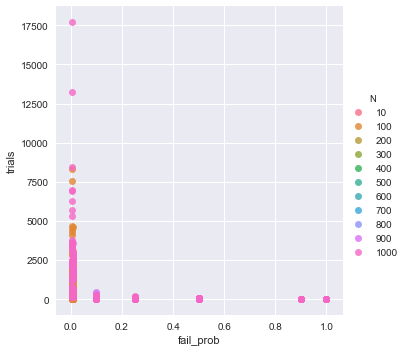

In [61]:
sn.lmplot(x='fail_prob', y='trials', data=df, hue='N', fit_reg=False) 

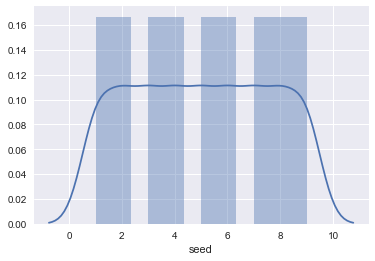

In [62]:
sn.distplot(df['seed'])

Not very helpful, the distribution of seeds. Basically between 1 and 9.

Trials vs Probability is not very informative. Not even, when I separate by 'N', the size of my history.

But I am suspecting that there is a bug for small probabilities. Let's filter those out.

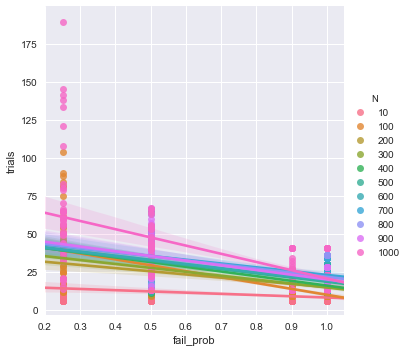

In [63]:
df_large_prob = df[df.fail_prob > 0.1]
sn.lmplot(x='fail_prob', y='trials', data=df_large_prob, hue='N')

That is more like it. 

1. The higher 'N', the more trials are needed. This is what I would expect.
2. The lower the failure probability, the more trials are needed. Again, that sounds very reasonable.

Next, let's do a violin plot to see the distribution at each probability.

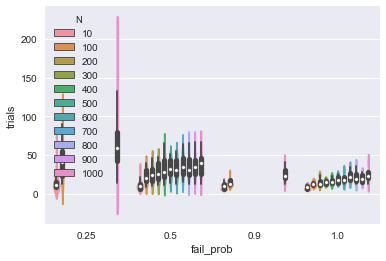

In [64]:
sn.violinplot(x='fail_prob', y='trials', hue='N',
                     data=df_large_prob)

Can you see anything? I can't. 

But, I think, I'd like to see the same for only `N = 1000` and `split` the Violin Plot on `success`. Because, honestly, I don't care much about `success == False` cases.

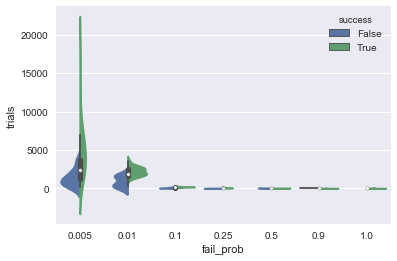

In [65]:
df_N1000 = df.query('N == 1000')
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000, split=True)

Very nice! First observation: Probabilities below 0.1 are different. Just, to be save, let's do a log-plot.
Second observation: At low probabilities success or failure makes all the difference to the number of trials.

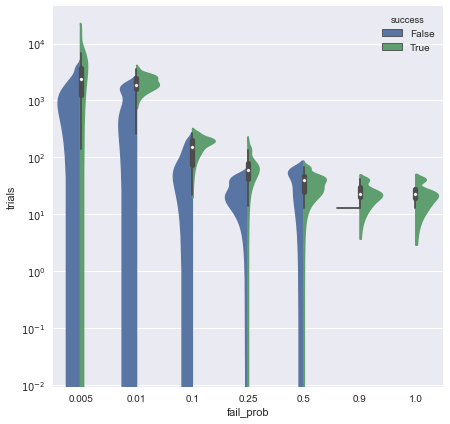

In [66]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000, split=True, ax=ax)

That looks certainly better, but for now, I want to limit my observation to p in [0.1, 1.0]. And stay with a linear axis.

Next, loet's repeat the step from above and show trials vs probabilites for N = 1000, and p >= 0.1

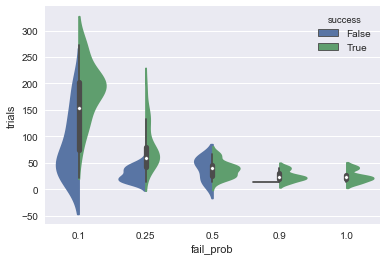

In [67]:
df_N1000_large_p = df.query('N == 1000').query('fail_prob >= 0.1')
sn.violinplot(x='fail_prob', y='trials', hue='success', data=df_N1000_large_p, split=True)

My colleague saw this the other day, and asked whether the distributions are bimodal. So, how many data points are there for each violin-plot?

In [68]:
df.query('N == 1000').groupby('fail_prob').size()

fail_prob
0.005    36
0.010    36
0.100    36
0.250    36
0.500    36
0.900    36
1.000    36
dtype: int64

192 values for 0.250. That seems enough.

Next, I want to produce another plot. Trials vs Commits to search, parameterised over p.

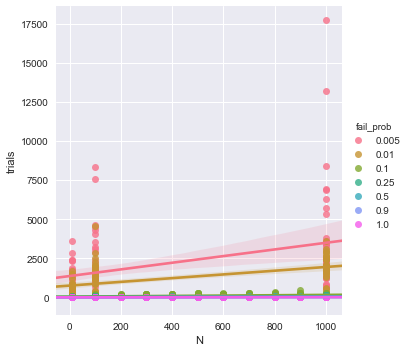

In [69]:
sn.lmplot(x='N', y='trials', data=df, hue='fail_prob')

Not useful at all.

1. I need some values for N between 100 and 1000.
2. There are too many 'hues' or 'fail_prob'. --> In the next plot, I will only pick [0.1, 0.5, 1.0].
3. That linear interpolation is obviously not what I want.
  * Let's turn it off.
  * Or, let's replace it with a `log(N)` regression. Why `log(N)`, because that is what I get with binary search.
  
Let's thin the plot down a bit:

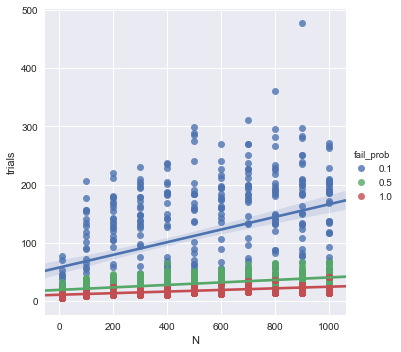

In [70]:
sn.lmplot(x='N', y='trials', data=df.query('fail_prob in [0.1, 0.5, 1.0]'), hue='fail_prob')

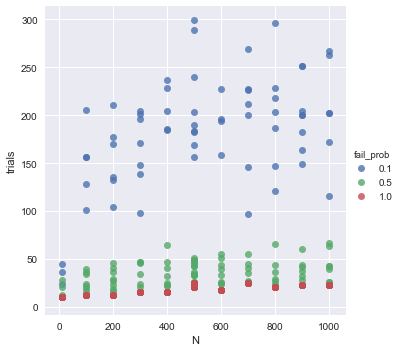

In [71]:
# Better, but let us try with only 'success'
locs = [int(0.5 * n) for n in set(df['N'])]
sn.lmplot(x='N', y='trials', data=df.query('fail_prob in [0.1, 0.5, 1.0] \
                                              and fail_loc in {} \
                                              and certainty == 0.9 \
                                              and success == True'.format(locs)),
          hue='fail_prob', fit_reg=False)

### Plot 3:  BBChop vs Git Bisect

How does BBChop fare against Git Bisect, if the fault is not intermittent. For that let's compare the graph of p = 1.0 and Git Bisect's `ceil(log(N, base=2))`.

<!-- -->

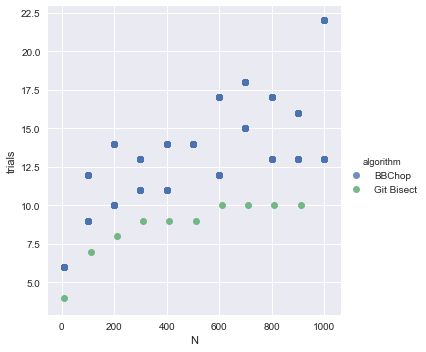

In [72]:
# df2: A view of [N, trials]
df2 = df.query('fail_prob == 1.0 and success == True and certainty == 0.7')[['N', 'trials']]
df2.insert(len(df2.columns), 'algorithm', 'BBChop')

# Git Bisect performance.
x = list(range(10, 1000, 100))
from math import ceil, log2
y = list(map(lambda n: ceil(log2(n)), x))
df3 = pd.DataFrame.from_items([('N', x), ('trials', y), ('algorithm', 'Git Bisect')])

sn.lmplot(x='N', y='trials', data=pd.concat([df2, df3]), hue='algorithm', fit_reg=False)

In [73]:
# Is the certainty accurate?

for c in [0.7, 0.9]:
    c_70 = df.query('certainty == {}'.format(c)).groupby('success').size()
    print('Success rate of algorithm: {}; expected {}.'.format( c_70[True] / (c_70[True] + c_70[False]), c))



Success rate of algorithm: 0.7197530864197531; expected 0.7.
Success rate of algorithm: 0.8666666666666667; expected 0.9.


## Discussion
The algorithm works.

## Appendix A: Comparing Log vs Linear Likelihoods

### Logarithmic Implementation
When running a test provided with *BBChop*, I noticed that for large number of detections, `Beta(d+1, t+1) * P(L)` evaluates to 0, for `d, t` being large (~ 640). This might be related to the poor performance at `p < 0.1`. [It is not, as my analysis later on shows.]

Developers with practical experience in probability algorithms know, that it is often advisable for numerical stability to use the logarithm of probabilities rather than raw probabilities. The developer of BBChop knew this too, which is obvious from his use of logarithms inside the math functions, and of his use of Fraction module to avoid floats.

However, `Beta` is implemented as
``` 
def Beta(a, b):
   return exp(log(Gamma(a)) + log(Gamma(b) - log(Gamma(a+b))
```

It was not obvious to me, how to make use of logarithms all the way through the computations. In retrospect, only a small change was required to fix the observed behaviour.

There is the line `for li in likelihoods: probs.append(li/likelihoodTot)`, with `likelihoodTot` being the sum over some `Beta(., .) * P(.)`.

One possible solution would be to use the identity `log(a + b) = log(a) + log(1 + b/a)`. 
http://stats.stackexchange.com/a/66621 : Suggests to "Substract the maximum logarithm from all logs."

This was indeed the solution.

\begin{align}
P_i &= \frac{L_i}{\sum_i L_i}
\end{align}

$\DeclareMathOperator*{\argmax}{argmax}$

Let $L_i$ be scaled by $k$, one sees that the above equation still holds. Thus $\log L_i = \log( \tilde{L_i}  k) = \log(\tilde{L_i}) + \log(k)$. Now, choose $\log(k)$ such that $\exp(\log(L_i))$ does not underflow. This can be achieved by making the largest value equal to 1. As such,  for $i = \argmax \log L_i$, $\exp(\log L_i ) = 1 \Leftrightarrow$   $\log L_i = 0 \Leftrightarrow$ $\log \tilde{L_i} = - \log k$. 

I implemented it and the code that erred now passes.

#### Evaluate if this made a difference.
In a [later section](#Comparing-Log-vs-Linear-Likelihoods) I show that this did not result in different results. However, my test data does not consist of so large number of observations. Remember the bug happens when 

> This fails for B(638 + 1, 664 + 1).

where 638 and 664 are the number of faulty and non-faulty (or absolute?) observations at a given location.


As mentioned above, not using Log Likelihoods was leading at a high number of observations to an underflow in the _exponential_.

Does this explain the bad performance at low probabilities?

In [74]:
with open('results_non_logarithm.json', 'r') as f: d = json.load(f)
df_non_log = pd.DataFrame.from_dict(d)
df_non_log.head()

,N,certainty,fail_loc,fail_prob,seed,success,trials,where
0,1000,0.7,700,0.010,1,False,629,904
1,1000,0.7,500,1.000,2,True,13,500
2,10,0.7,7,0.005,4,True,1238,7
3,100,0.9,50,0.010,1,True,1276,50
4,100,0.9,50,0.250,1,True,47,50


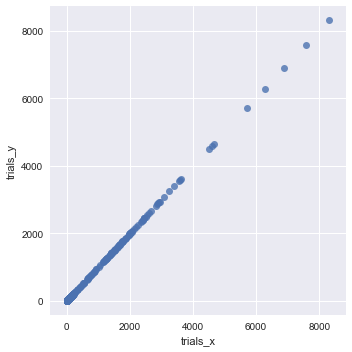

In [75]:
# Maybe a good comparison between Log vs Linear is for each config plot trials[log] vs trials[lin]? 

# Drop duplicates
df_non_log.drop_duplicates(inplace=True)

merge = pd.merge(df, df_non_log, on = ['N', 'certainty', 'fail_loc', 'fail_prob', 'seed', 'where'], how='inner')

trials_log = merge['trials_x']
trials_lin = merge['trials_y']

sn.lmplot(x='trials_x', y='trials_y', data = merge, fit_reg=False)

In [76]:
non_equals = merge.query('trials_x != trials_y')
assert(len(non_equals) == 0)

This shows that the behavior is the same before and after fixing the exponential-underflow bug.



## 

## Appendix B: An alternative method of computation

Algorithm:
```
# Run binary search on the history.
1. Pick the midpoint of the history.
2. Run the test.
3. While test passes and number of test runs at current location is less then $k$, continue running the test at current location.
4. Mark the current midpoint as either failed or passed according to the result from line 3.
5. Compute the next midpoint and continue from line 1, if there is still a midpoint.
```


This algorithm would have the following characteristics.

The certainty of not misclassifying a location $c_i$ is $c_i \lt 1 - (1 - p)^k$. The certainty of not misclassifying any location is $c = \Pi_i^n c_i = \Pi_i^n 1 - (1-p)^k = (1 - (1-p)^k)^n$. $p$ is the fault probability, $n$ is the number of locations to evaluate. As such we have $n = \left\lceil \log_2 N \right\rceil$. We can re-arrange this to find the number of tests that we have to evaluate at each location $k$. $k = \left\lceil \frac{\log (1 - \exp(\log c / n) )}{\log (1-p)} \right\rceil$ (Valid for $p \lt 1$.)

The maximum number of trials to undertake become: 

\begin{align}
k n &= \left\lceil \frac{\log (1 - \exp(\log c / n) )}{\log (1-p)} \right\rceil n \\
\end{align}

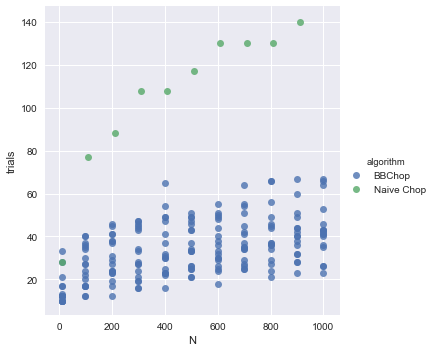

In [77]:
p = 0.5
certainty = 0.9

condition = 'fail_prob == {p} and success == True and certainty == {cert}'.format(p=p, cert=certainty)
df2 = df.query(condition)[['N', 'trials']]
df2.insert(len(df2.columns), 'algorithm', 'BBChop')


# Naive Chop performance.
x = list(range(10, 1000, 100))
from math import ceil, log2, log, exp
f_n = lambda n: ceil(log2(n))
numerator = lambda n: log(1 - exp(log(certainty) / n))
f = lambda n: ceil(numerator(n) / log(1-p)) * f_n(n)

# Average case
# f = lambda n: ceil(log2(n)) * (ceil(0.5 * 1. / p) + ceil(0.5 * log(1-certainty)/log(1-p)))
y = list(map(f, x))
df3 = pd.DataFrame.from_items([('N', x), ('trials', y), ('algorithm', 'Naive Chop')])

sn.lmplot(x='N', y='trials', data=pd.concat([df2, df3]), hue='algorithm', fit_reg=False)

From this it may safely be assumed that *BBChop* has better complexity than *Naive Chop*. However, this is less clear for the expected number of trials needed.